In [1]:
import sys
import os
# sys.path.append("/home/trahlmeier/seizeit_neu2")
sys.path.append("/home/jhagenbe_sw/ASIM/seizeit2/")
# sys.path.append("/home/swolf/asim_shared/raw_data/ds005873-1.1.0")
# sys.path.append(os.path.join('..', 'Information', 'Data', 'seizeit2-main'))

# import seizeit2  # testweise

from net.utils import mask2eventList, post_events, perf_measure_epoch, preprocess_data


KeyboardInterrupt: 

In [13]:
from seizeit.common.paths import DATA_FOLDER_PATH, SCRATCH_PATH
from seizeit.common.paths import PROJ_ROOT_PATH
from seizeit.classes.data import Data
from stumpy import scrump, stump
import numpy as np
from seizeit.classes.annotation import Annotation
from scipy.stats import percentileofscore
from seizeit.net.utils import mask2eventList, post_events, perf_measure_epoch, preprocess_data
import pandas as pd
from tqdm import tqdm
import os
import warnings

def _get_recording_data(rec, verbose=False) -> Data:
    if verbose: print(f"Recording: {rec[0]} {rec[1]}")
    try:
        data = Data.loadData(DATA_FOLDER_PATH, rec, ["eeg", "ecg", "emg"])
    except Exception as e:
        raise ValueError(f"Could not load data for {rec}: {e}")

    if not data.data or not data.fs:
        raise ValueError(f"No data loaded for recording: {rec}")

    # Replace missing channels with flat lines (0s)
    min_len = min([len(ch) for ch in data.data]) if data.data else 0
    if min_len == 0:
        raise ValueError(f"Empty data arrays in {rec}")

    expected_channels = 3  # eeg, ecg, emg
    while len(data.data) < expected_channels:
        warnings.warn(f"Missing channel detected in {rec}, adding flat line.")
        data.data.append(np.zeros(min_len))
        data.fs.append(data.fs[0] if data.fs else 256)  # default fallback fs

    return data

def get_matrix_profile(data: Data, subsampling_factor=16, approximate=True):
    window_size = int(data.fs[0] / subsampling_factor)
    chunk_size = window_size * 1800

    # Apply Stumpy to each channel
    mp_list = []
    for channel in range(len(data.data)):
        chunk_profiles = []
        data_channel = data.data[channel][::subsampling_factor]
        for i in range(0, len(data_channel), chunk_size):
            if i == 0:
                chunk = np.concatenate([[data_channel[0]] * (window_size - 1), data_channel[i:i + chunk_size]], axis=0)
            else:
                chunk = data_channel[i - (window_size - 1):i + chunk_size]
            chunk_std = np.std(chunk)
            if chunk_std != 0:
                chunk = (chunk - np.mean(chunk)) / np.std(chunk)  # Normalize chunk
            if approximate:
                approx = scrump(chunk, window_size, percentage=0.1, pre_scrump=True)
                profile = approx.P_
            else:
                profile = stump(chunk, window_size)[:, 0]
            chunk_profiles.append(profile)

        mp = np.concatenate(chunk_profiles)
        mp_list.append(mp)

    return np.array(mp_list)
def _get_fah_epoch(annotation, prediction_score, threshold, prediction_fs) -> float:
    prediction_mask = prediction_score >= threshold
    pred_events = mask2eventList(prediction_mask, prediction_fs)
    _, FP, _, _ = perf_measure_epoch(annotation.events, pred_events, annotation.rec_duration)
    return FP * 3600 / annotation.rec_duration

def _get_max_prediction_score_for_seizures(rec, prediction, prediction_fs):
    normalized_prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
    annot = Annotation.loadAnnotation(DATA_FOLDER_PATH, rec)
    seizure_events = annot.events
    max_scores = []
    
    if not seizure_events:  # No seizures in ground truth
        prediction_mask = prediction >= np.percentile(prediction, 99)  # or use your actual threshold
        pred_events = mask2eventList(prediction_mask, prediction_fs)
        FAH = len(pred_events) * 3600 / annot.rec_duration if annot.rec_duration else 0
        max_scores.append({
            "max": None,
            "max_normalized": None,
            "max_percentile": None,
            "max_fah_epoch": FAH
        })
        print(max_scores)
    else:     
        for seizure in seizure_events:
            seizure_start = int(seizure[0] * prediction_fs)
            seizure_end = int(seizure[1] * prediction_fs)
            max_scores.append({
                "max": float(np.max(prediction[seizure_start:seizure_end])),
                "max_normalized": float(np.max(normalized_prediction[seizure_start:seizure_end])),
                "max_percentile": float(percentileofscore(prediction, np.max(prediction[seizure_start:seizure_end]))),
                "max_fah_epoch": _get_fah_epoch(annot, prediction, np.max(prediction[seizure_start:seizure_end]),
                                                prediction_fs)
            })
            print(max_scores)
    return max_scores

def get_events_from_mask(mask, fs, post_process=False, verbose=False):
    events = mask2eventList(mask, fs=fs)
    if post_process: events = post_events(events, margin=10)
    if verbose: print(f"Identified anomalous events: {len(events)}")

    return events


def get_anomalous_events_stumpy(rec, subsampling_factor=16, approximate=False, contamination=0.01, verbose=False, save_results=False):
    data = _get_recording_data(rec, verbose=verbose)
    window_size = int(data.fs[0] / subsampling_factor)

    matrix_profile = get_matrix_profile(data, subsampling_factor=subsampling_factor, approximate=approximate)
    #if save_results: np.savez(SCRATCH_PATH / "save_dir" / "predictions" / "Stumpy" / "16-subsampling_scrumpy" / f"{rec[0]}_{rec[1]}.npz", matrix_profile)
    if save_results:
        save_path = SCRATCH_PATH / "save_dir" / "predictions" / "Stumpy" / "16-subsampling_scrumpy_bckg"
        os.makedirs(save_path, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden
        np.savez(save_path / f"{rec[0]}_{rec[1]}.npz", matrix_profile)
    # Combine the matrix profiles
    combined_mp = np.max(matrix_profile, axis=0)
    max_score_for_seizures = _get_max_prediction_score_for_seizures(rec, combined_mp, window_size)

    threshold = np.percentile(combined_mp, 100 * (1 - contamination))
    events = get_events_from_mask(mask=combined_mp > threshold, fs=window_size, verbose=verbose)
    return max_score_for_seizures, events

df_events = pd.DataFrame({'subject': pd.Series(dtype='object'),
                          'run': pd.Series(dtype='object'),
                          'max_scores_for_seizures': pd.Series(dtype='object'),
                          'events': pd.Series(dtype='object'),
                          'number_of_events': pd.Series(dtype='int32'),
                          'duration_of_events': pd.Series(dtype='int32')
                          })
"""
df = pd.read_csv(PROJ_ROOT_PATH / "notebooks" / "seizures_mini.csv")
df.sort_values(by=["subject", "run"], inplace=True)
seizure_recordings = df[["subject", "run"]].drop_duplicates().apply(list, axis=1).tolist()

for rec in tqdm(seizure_recordings[:]):
        max_scores_for_seizures, anomalous_events = get_anomalous_events_stumpy(rec, subsampling_factor=16, approximate=True, verbose=False, save_results=True)
        df_events.loc[len(df_events)] = [rec[0], rec[1], max_scores_for_seizures, anomalous_events,
                                         len(anomalous_events),
                                         sum([e[1] - e[0] for e in anomalous_events])]

"""

'\ndf = pd.read_csv(PROJ_ROOT_PATH / "notebooks" / "seizures_mini.csv")\ndf.sort_values(by=["subject", "run"], inplace=True)\nseizure_recordings = df[["subject", "run"]].drop_duplicates().apply(list, axis=1).tolist()\n\nfor rec in tqdm(seizure_recordings[:]):\n        max_scores_for_seizures, anomalous_events = get_anomalous_events_stumpy(rec, subsampling_factor=16, approximate=True, verbose=False, save_results=True)\n        df_events.loc[len(df_events)] = [rec[0], rec[1], max_scores_for_seizures, anomalous_events,\n                                         len(anomalous_events),\n                                         sum([e[1] - e[0] for e in anomalous_events])]\n\n'

In [14]:
from seizeit.classes.annotation import Annotation
from seizeit.common.paths import DATA_FOLDER_PATH
from seizeit.net.utils import mask2eventList, get_metrics
from joblib import Parallel, delayed


def process_threshold(th, y_pred, true_events, fs=16):
    threshold = np.percentile(y_pred, 100 * th)
    pred = (y_pred > threshold)
    pred_events = mask2eventList(pred, fs)
    
    duration_hours = len(y_pred) / fs / 3600

    if not true_events:  # No seizures in ground truth
        fah_epoch_rec = len(pred_events) / duration_hours if duration_hours > 0 else 0
        result = {
            "sens_ovlp_rec": 0.0,
            "fah_epoch_rec": fah_epoch_rec,
            "threshold": th,
            "score": -0.4 * fah_epoch_rec,
            "pred_event_total": len(pred_events),
            "pred_time_total": sum(pred),
        }
        return result

    sens_ovlp_rec, _, _, _, _, _, _, fah_epoch_rec, _ = get_metrics(
        true_events, pred_events, len(y_pred) / fs)
    result = {
        "sens_ovlp_rec": sens_ovlp_rec,
        "fah_epoch_rec": fah_epoch_rec,
        "threshold": th,
        "score": sens_ovlp_rec * 100 - 0.4 * fah_epoch_rec,
        "pred_event_total": len(pred_events),
        "pred_time_total": sum(pred),
    }
    return result


def evaluate(y_pred, true_events, thresholds):
    results_per_threshold = Parallel(n_jobs=16)(delayed(process_threshold)(th, y_pred, true_events) for th in thresholds)
    #results_per_threshold = [process_threshold(th, y_pred, true_events) for th in thresholds]
    return results_per_threshold


import numpy as np

thresholds = np.array(np.around(np.linspace(0.97, 1, 31), 3))
thresholds_dict = {threshold: i for i, threshold in enumerate(thresholds)}
print(thresholds)

[0.97  0.971 0.972 0.973 0.974 0.975 0.976 0.977 0.978 0.979 0.98  0.981
 0.982 0.983 0.984 0.985 0.986 0.987 0.988 0.989 0.99  0.991 0.992 0.993
 0.994 0.995 0.996 0.997 0.998 0.999 1.   ]


In [15]:
def get_matrix_profiles(model, instance):
    from seizeit.common.paths import SCRATCH_PATH

    folder_path = SCRATCH_PATH / "save_dir" / "predictions" / model / instance
    import os

    files = [file[:-len(".npz")] for file in sorted(os.listdir(folder_path)) if
             os.path.isfile(os.path.join(folder_path, file))]

    mps = {(file[:7], file[8:]): np.load(folder_path / f"{file}.npz", allow_pickle=True)["arr_0"] for file in files}

    return mps

mps = get_matrix_profiles("Stumpy", "16-subsampling_scrumpy_bckg")


mps = get_matrix_profiles("Stumpy", "16-subsampling_scrumpy")

'''def get_matrix_profiles(model, instance):
    import os
    import numpy as np
    from seizeit.common.paths import SCRATCH_PATH

    folder_path = SCRATCH_PATH / "save_dir" / "predictions" / model / instance

    if not folder_path.exists():
        raise FileNotFoundError(f"Directory not found: {folder_path}")

    # Filter for files that contain "sub-001" or "sub-002"
    files = [
        file[:-len(".npz")] for file in sorted(os.listdir(folder_path))
        if (
            file.endswith(".npz") and
            ("sub-001" in file or "sub-002" in file) and
            os.path.isfile(os.path.join(folder_path, file))
        )
    ]

    mps = {
        (file[:7], file[8:]): np.load(folder_path / f"{file}.npz", allow_pickle=True)["arr_0"]
        for file in files
    }

    return mps

mps = get_matrix_profiles("Stumpy", "16-subsampling_scrumpy_bckg")
'''


'def get_matrix_profiles(model, instance):\n    import os\n    import numpy as np\n    from seizeit.common.paths import SCRATCH_PATH\n\n    folder_path = SCRATCH_PATH / "save_dir" / "predictions" / model / instance\n\n    if not folder_path.exists():\n        raise FileNotFoundError(f"Directory not found: {folder_path}")\n\n    # Filter for files that contain "sub-001" or "sub-002"\n    files = [\n        file[:-len(".npz")] for file in sorted(os.listdir(folder_path))\n        if (\n            file.endswith(".npz") and\n            ("sub-001" in file or "sub-002" in file) and\n            os.path.isfile(os.path.join(folder_path, file))\n        )\n    ]\n\n    mps = {\n        (file[:7], file[8:]): np.load(folder_path / f"{file}.npz", allow_pickle=True)["arr_0"]\n        for file in files\n    }\n\n    return mps\n\nmps = get_matrix_profiles("Stumpy", "16-subsampling_scrumpy_bckg")\n'

In [16]:
channels = ["eeg0", "eeg1", "ecg", "emg"]
predictions = {ch: {rec: mp[i, :] if i < mp.shape[0] else np.zeros((mp.shape[1])) for rec, mp in mps.items()} for i, ch
               in enumerate(channels)}
predictions["max_all"] = {rec: np.max(mp, axis=0) for rec, mp in mps.items()}
predictions["max_eeg1_ecg"] = {rec: np.max(mp[1:2,:], axis=0) for rec, mp in mps.items()}

models = list(predictions.keys())

In [18]:
results = list()

for model in models:
    for rec, prediction in tqdm(predictions[model].items()):
        annot = Annotation.loadAnnotation(DATA_FOLDER_PATH, rec)
        labeled_events = annot.events
        has_seizures = len(labeled_events) > 0
        rec_duration = annot.rec_duration if annot.rec_duration else len(prediction) / 16  # Fallback fs = 16

        try:
            results_per_threshold = evaluate(prediction, labeled_events, thresholds)
        except ZeroDivisionError:
            print(f"Skipped due to division error in {model} - {rec}")
            continue

        results.append({
            "model": model,
            "rec": rec,
            "duration": rec_duration,
            "has_seizures": has_seizures,
            "scores": [res["score"] for res in results_per_threshold],
            "sens_ovlp_rec": [res["sens_ovlp_rec"] for res in results_per_threshold],
            "fah_epoch_rec": [res["fah_epoch_rec"] for res in results_per_threshold],
            "pred_event_totals": [res["pred_event_total"] for res in results_per_threshold],
            "pred_time_totals": [res["pred_time_total"] for res in results_per_threshold],
            "true_event_total": len(labeled_events),
            "true_time_total": sum([e[1] - e[0] for e in labeled_events]),
        })

  0%|          | 0/396 [00:00<?, ?it/s]2025-04-21 08:48:05.361864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:48:05.373769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:48:05.376884: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:48:05.376889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-p

Skipped due to division error in eeg0 - ('sub-073', 'run-20')


2025-04-21 08:49:00.616947: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:00.616947: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:00.629284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:49:00.629466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in eeg0 - ('sub-081', 'run-45')


2025-04-21 08:49:14.518009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:14.518010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:14.518011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:14.518013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg0 - ('sub-085', 'run-34')


2025-04-21 08:49:18.221459: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:18.225116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:18.235498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:49:18.236657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in eeg0 - ('sub-087', 'run-09')


2025-04-21 08:49:22.148776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:22.148776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:22.148776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:22.148776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg0 - ('sub-087', 'run-17')


2025-04-21 08:49:25.792862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:25.793591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:25.793591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:25.805055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg0 - ('sub-087', 'run-23')


2025-04-21 08:49:29.221923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:29.221923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:29.221923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:29.221923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg0 - ('sub-090', 'run-02')


2025-04-21 08:49:32.923693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:32.923933: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:32.923933: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:32.933824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg0 - ('sub-097', 'run-10')


2025-04-21 08:49:38.478358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:38.478358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:38.480724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:49:38.490914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg0 - ('sub-122', 'run-24')


2025-04-21 08:50:00.121601: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:00.123505: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:00.133714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:50:00.134989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in eeg1 - ('sub-026', 'run-01')


2025-04-21 08:50:19.487214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:19.487214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:19.497437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:19.497440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg1 - ('sub-034', 'run-04')


2025-04-21 08:50:26.982637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:26.982635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:26.993198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:50:26.993191: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg1 - ('sub-084', 'run-05')


2025-04-21 08:51:11.378142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:11.378140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:11.378193: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:11.390621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg1 - ('sub-085', 'run-34')


2025-04-21 08:51:14.848430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:14.848430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:14.848431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:14.860891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg1 - ('sub-087', 'run-05')


2025-04-21 08:51:18.593581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:18.593580: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:18.593583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:18.593580: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg1 - ('sub-087', 'run-20')


2025-04-21 08:51:22.715916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:22.716454: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:22.728126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:51:22.728126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in eeg1 - ('sub-087', 'run-22')


2025-04-21 08:51:26.065091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:26.065099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:26.065092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:26.071146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg1 - ('sub-091', 'run-02')


2025-04-21 08:51:29.964288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:29.964286: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:29.976707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:51:29.976707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in eeg1 - ('sub-091', 'run-03')


2025-04-21 08:51:33.227667: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:33.227668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:33.231631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:33.240166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg1 - ('sub-091', 'run-04')


2025-04-21 08:51:36.503120: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:36.503118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:36.510180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:36.511460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in eeg1 - ('sub-097', 'run-10')


2025-04-21 08:51:41.831048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:41.831049: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:41.831050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:51:41.843345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg1 - ('sub-122', 'run-24')


2025-04-21 08:52:02.939112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:02.939111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:02.939112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:02.951391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in eeg1 - ('sub-125', 'run-37')


  0%|          | 0/396 [00:00<?, ?it/s]2025-04-21 08:52:06.487482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:06.487482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:06.499330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:06.499330: I tensorflow/core/util/port.cc:153] oneDNN custom o

Skipped due to division error in ecg - ('sub-073', 'run-20')


2025-04-21 08:52:51.997435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:51.997435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:51.997435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:52:51.997433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in ecg - ('sub-076', 'run-01')


2025-04-21 08:53:00.151314: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:00.151934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:00.157895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:00.157897: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in ecg - ('sub-086', 'run-29')


2025-04-21 08:53:07.479852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:07.479851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:07.479852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:07.489316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in ecg - ('sub-087', 'run-05')


2025-04-21 08:53:11.049735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:11.049735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:11.049735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:11.049735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in ecg - ('sub-087', 'run-17')


2025-04-21 08:53:14.875426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:14.879863: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:14.887368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:53:14.891674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in ecg - ('sub-091', 'run-02')


2025-04-21 08:53:19.020738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:19.025764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:19.025761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:19.025765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in ecg - ('sub-091', 'run-03')


2025-04-21 08:53:22.295188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:22.295188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:22.295190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:22.307725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in ecg - ('sub-092', 'run-50')


2025-04-21 08:53:25.739165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:25.739165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:25.751780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:53:25.751884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in ecg - ('sub-123', 'run-50')


2025-04-21 08:53:46.734849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:46.734848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:46.734849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:53:46.747118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in emg - ('sub-073', 'run-20')


2025-04-21 08:54:39.416187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:39.416188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:39.416187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:39.427540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in emg - ('sub-084', 'run-21')


2025-04-21 08:54:53.005538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:53.012700: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:53.012702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:53.012701: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in emg - ('sub-085', 'run-34')


2025-04-21 08:54:56.329040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:56.329041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:54:56.341542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:54:56.341541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in emg - ('sub-087', 'run-05')


2025-04-21 08:55:00.099811: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:00.105450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:00.105447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:00.107283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in emg - ('sub-087', 'run-17')


2025-04-21 08:55:03.895151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:03.895151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:03.906213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:03.907723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in emg - ('sub-091', 'run-04')


2025-04-21 08:55:08.050755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:08.050756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:08.060997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:08.060997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in emg - ('sub-122', 'run-24')


2025-04-21 08:55:29.885671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:29.885670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:29.885670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:55:29.895343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_all - ('sub-073', 'run-20')


2025-04-21 08:56:24.942264: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:24.942263: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:24.942265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:24.942264: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_all - ('sub-085', 'run-34')


2025-04-21 08:56:39.969635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:39.969630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:39.969632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:39.980767: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_all - ('sub-087', 'run-05')


2025-04-21 08:56:43.757670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:43.757670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:43.757670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:43.767028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_all - ('sub-087', 'run-09')


2025-04-21 08:56:47.279372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:47.279373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:47.279373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:47.284795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_all - ('sub-091', 'run-02')


2025-04-21 08:56:51.709718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:51.712855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:51.718056: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:51.721803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in max_all - ('sub-097', 'run-10')


2025-04-21 08:56:57.234949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:57.234953: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:57.234949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:56:57.234950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_all - ('sub-122', 'run-24')


2025-04-21 08:57:17.813181: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:17.813180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:17.819218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:17.820510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_eeg1_ecg - ('sub-026', 'run-01')


2025-04-21 08:57:36.631335: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:36.636347: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:36.636350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:36.636345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_eeg1_ecg - ('sub-034', 'run-04')


2025-04-21 08:57:43.967216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:43.979431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:57:43.982531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:57:43.982530: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different co

Skipped due to division error in max_eeg1_ecg - ('sub-084', 'run-05')


2025-04-21 08:58:27.767984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:27.767984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:27.767982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:27.780601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in max_eeg1_ecg - ('sub-085', 'run-34')


2025-04-21 08:58:31.141004: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:31.141007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:31.153526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:58:31.153526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Skipped due to division error in max_eeg1_ecg - ('sub-087', 'run-05')


2025-04-21 08:58:34.824569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:34.824569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:34.824569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:34.831803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_eeg1_ecg - ('sub-087', 'run-20')


2025-04-21 08:58:38.692554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:38.704767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 08:58:38.707509: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:38.707510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different co

Skipped due to division error in max_eeg1_ecg - ('sub-087', 'run-22')


2025-04-21 08:58:42.009228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:42.009228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:42.019212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:42.022007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in max_eeg1_ecg - ('sub-091', 'run-02')


2025-04-21 08:58:45.906637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:45.915163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:45.917731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:45.917731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_eeg1_ecg - ('sub-091', 'run-03')


2025-04-21 08:58:49.175344: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:49.175344: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:49.179457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:49.187911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in max_eeg1_ecg - ('sub-091', 'run-04')


2025-04-21 08:58:52.458634: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:52.458630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:52.458634: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:52.470966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fa

Skipped due to division error in max_eeg1_ecg - ('sub-097', 'run-10')


2025-04-21 08:58:57.893751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:57.894264: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:57.904740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:58:57.904740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_eeg1_ecg - ('sub-122', 'run-24')


2025-04-21 08:59:19.628849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:59:19.628848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:59:19.628849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 08:59:19.628849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Skipped due to division error in max_eeg1_ecg - ('sub-125', 'run-37')


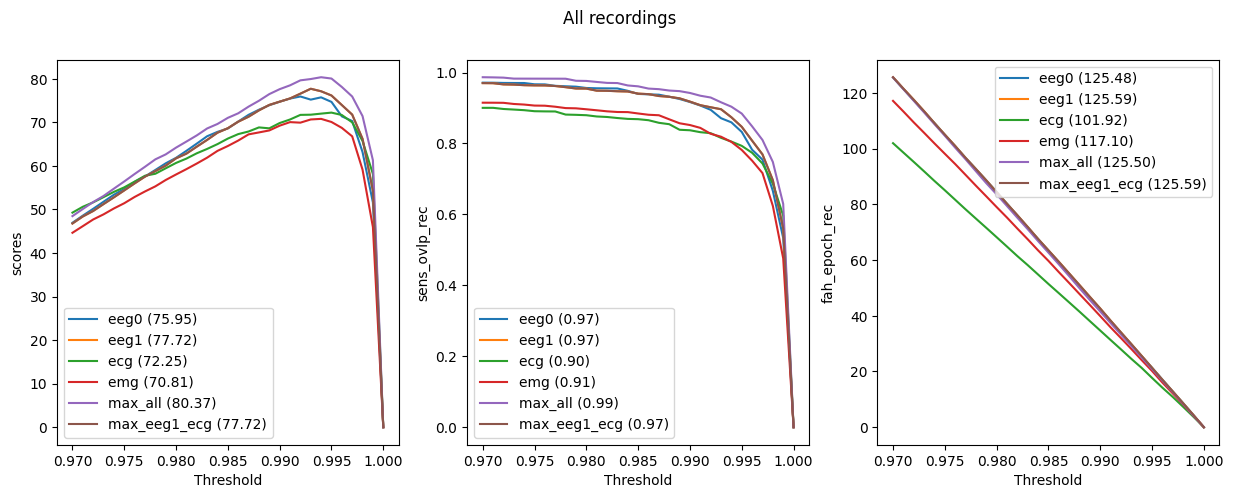

In [19]:
from matplotlib import pyplot as plt
import pandas as pd


def plot_scores(recordings, title="", filter_has_seizures=None):
    df_results = pd.DataFrame(results)

    # Optional filtering by seizure presence
    if filter_has_seizures is not None:
        df_results = df_results[df_results["has_seizures"] == filter_has_seizures]

    df_results["fixed threshold"] = np.nan
    metrics = ["scores", "sens_ovlp_rec", "fah_epoch_rec"]
    fig = plt.figure(figsize=(15, 5))

    for m, metric in enumerate(metrics):
        ax = fig.add_subplot(1, len(metrics), m+1)
        for model in models:
            df_model = df_results[df_results["model"] == model]
            df_model = df_model[df_model["rec"].isin(recordings)]

            # Filter out any rows where the metric is missing or malformed
            df_model = df_model[df_model[metric].apply(lambda x: isinstance(x, list) and len(x) == len(thresholds))]
            if df_model.empty:
                continue

            scores_mat = np.array(df_model[metric].tolist())
            scores_mean = np.mean(scores_mat, axis=0)
            best_threshold = scores_mean.argmax()
            df_results.loc[df_results["model"] == model, "fixed threshold"] = thresholds[best_threshold]
            ax.plot(thresholds, scores_mean, label=f"{model} ({np.max(scores_mean):.2f})")

        ax.legend()
        ax.set_ylabel(metric)
        ax.set_xlabel("Threshold")

    fig.suptitle(title)
    plt.show()


# %%
all_recordings = [rec for rec, mp in mps.items()]
missing_data_rec = [rec for rec, mp in mps.items() if len(mp) < 4]
complete_rec = [rec for rec, mp in mps.items() if len(mp) == 4]

models = list(predictions.keys())
#models = models[:-1]

### nur wenn auch EKG/EMG Daten fehlen 
plot_scores(recordings = all_recordings, title = "All recordings")
    
#for recordings, title in zip([all_recordings, missing_data_rec, complete_rec],
#                             ["All recordings", "Missing Data recordings", "Complete Data recordings"]):
#    plot_scores(recordings, title)

